<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.2: K-Means bad cases

INSTRUCTIONS:

- Replace the `___` with proper code to run the cells
- Observe and understand the results
- Answer the questions

In [46]:
## Import Libraries

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

# from sklearn import datasets
from sklearn.datasets import make_circles
import seaborn as sbn

In [47]:
## Create data points (circles)

# Make Random Circles
X1, Y1 = make_circles(n_samples = 400, factor = 0.3, noise = 0.05)

In [48]:
print(X1.shape)
print(Y1.shape)

(400, 2)
(400,)


In [49]:
## Convert data into a DataFrame

# Declare the column names
columns = 'A B'.split()

# Load the dataset as a pandas data frame
X = pd.DataFrame(X1, columns = columns)

In [50]:
## Check data

# About X
print('X is a %s' % type(X))
print('X has %d rows and %d columns' % X.shape)
print('Basic Statistics about X%s' % ('_'*50))
print(X.describe())
print('')
print('Sample of X%s' % ('_'*50))
print(X.head())

X is a <class 'pandas.core.frame.DataFrame'>
X has 400 rows and 2 columns
Basic Statistics about X__________________________________________________
                A           B
count  400.000000  400.000000
mean    -0.001109   -0.002815
std      0.526485    0.527363
min     -1.076032   -1.064726
25%     -0.284646   -0.296776
50%      0.004039    0.009502
75%      0.279258    0.289777
max      1.097946    1.049935

Sample of X__________________________________________________
          A         B
0 -0.970558 -0.040465
1 -0.310832 -0.001668
2 -0.352992 -0.200828
3 -0.196499  0.066483
4 -0.127880  1.009306


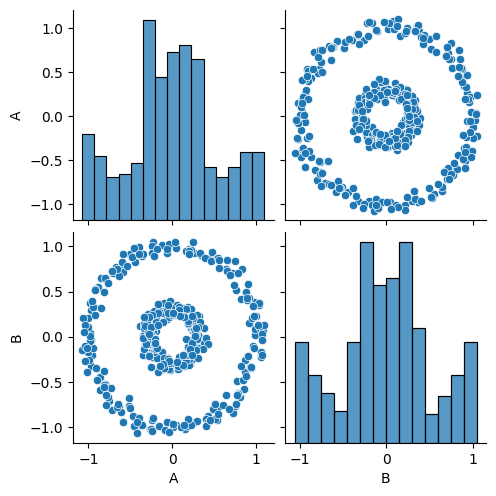

In [51]:
sbn.pairplot(X)
plt.show()

### Question 1: What are other important things to know about the data? Comment on:
- Types
- Availability
- Dispersion and Distribution

### Question 2: Which features could/should be used to cluster the data points?

## Answer 1 : 
### Type 
Types
Features: The data consists of two continuous numerical features: 'A' and 'B'.
Target: Although not explicitly used in this snippet, the make_circles function also generates labels Y1, which are categorical (binary).

Availability
The dataset is synthetically generated using the make_circles function from sklearn.datasets. This function is readily available and customizable for generating circular data patterns with specified sample sizes, noise levels, and factors.

Dispersion and Distribution
Feature A: The feature 'A' ranges approximately between -1.2 to 1.05. The distribution is likely to show two distinct clusters when plotted against 'B'.
Feature B: The feature 'B' ranges approximately between -1.06 to 1.10. Similar to 'A', 'B' is expected to show two distinct clusters.
The pair plot will reveal circular patterns indicating the distribution and dispersion of the data points. It will show two circles, one within the other, demonstrating the clusters' separation

In [52]:
## Create some supporting functions

def create_centroids(K, features):
    # start with no centroids
    centroids = []
    # need one centroid for each cluster
    for i in range(K):
        # it can be multi-dimensional
        dimensions = []
        for f in features:
            # create a random number between the minimum and maximum of each feature
            x = np.random.uniform(features[f].min(), features[f].max())
            dimensions.append(x)
        # add all dimensions for the centroids of each cluster
        centroids.append(dimensions)

    return centroids

In [53]:
# Identify the closest centroid for a given data point
def closest_centroid(x, centroids):
    distances = []
    # convert x to a numpy.array; x contains all the features of a data point
    p = np.array(x)
    for c in centroids:
        # convert c to a numpy.array; c contains the coordinates for all the features
        q = np.array(c)
        # calculate the Euclidean distance between data point `x` and centroid `c`
        d = np.linalg.norm(p - q)
        # add the distance for each centroid
        distances.append(d)

    # return the position (cluster) which is the closest centroid
    return np.argmin(distances)

In [54]:
# recalculate all the centroids based on the mean of the members of each cluster
def update_centroid(X, y, centroids):
    c = []
    # for each of the existing centroids
    for i in range(len(centroids)):
        # check if any object was assigned to a cluster
        if X[y == i].shape[0]:
            dimensions = []
            # for all the features
            for f in X.columns:
                # calculate the mean of the feature f for the cluster i
                x = X[y == i][f].mean()
                dimensions.append(x)
            c.append(dimensions)
        # if a cluster got no members
        else:
            # keep the previous coordinates
            c.append(centroids[i])

    return c

In [55]:
# plot a chart of the data points and centroids either generic or identifying the clusters
# NOTE: for visualisation purposes, only consider the first two features


def plot_data(ax, X, y, centroids, show_clusters=True):
    # unpack the coordinates of the centroids
    a = [z[0] for z in centroids]
    b = [z[1] for z in centroids]

    # show distinct colours if asked to identify the clusters
    if show_clusters:
        colours = 'rgbykcm'
        for i in range(len(centroids)):
            ax.scatter(X.iloc[y == i, 0], X.iloc[y == i, 1], c=colours[i], label='Cluster %d' % i)
    # show data points without cluster identification
    else:
        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], label='Data Point')

    # label the features
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])

    # identify the centroids
    ax.scatter(a, b, c='k', linewidths=5, marker='x', label='Centroid')
    for i in range(len(a)):
        c = colours[i] if show_clusters else 'k'
        ax.axvline(x=a[i], color=c, linestyle='--', linewidth=1)
        ax.axhline(y=b[i], color=c, linestyle='--', linewidth=1)

    # create a text to show the centroids' coordinates
    t = '\n'.join(['%d: (%.3f, %.3f)' % (i, a, b) for (i, (a, b)) in enumerate(centroids)])
    ax.text(0.69, -1.1, t)

    ax.legend()

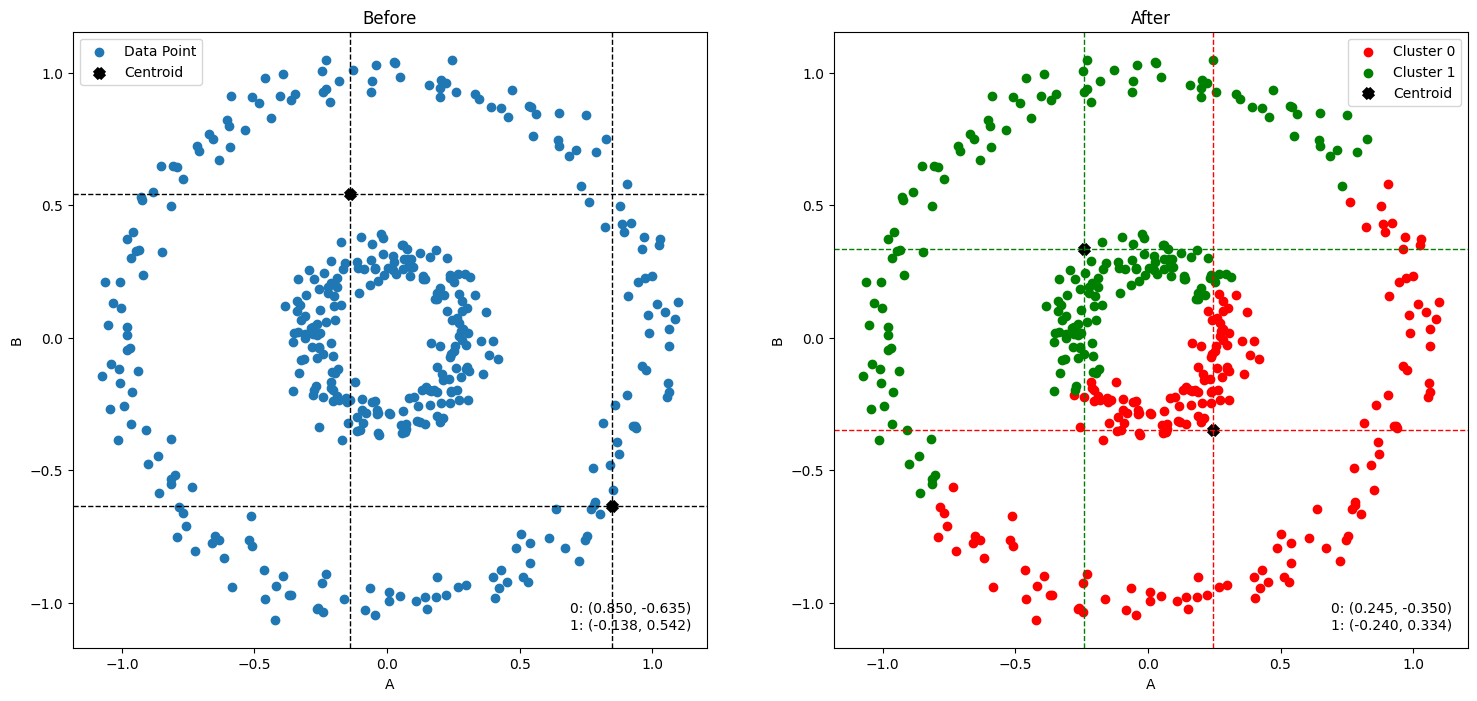

In [56]:
## K_Means
## Note that the comments match the outlined K-Means Algorithm in the presentation

# 1. Define the number of clusters `K`
K = 2  # choose different values for `K`

# list the features to be used
features = ['A', 'B']

# 2. Select `K` cluster centres randomly
centroids = create_centroids(K, X)

# plot the data points and initial centroids (the 'Before')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
plot_data(axes[0], X[features], None, centroids, False)
axes[0].set_title("Before")

# repeat until no changes in centroids
while True:
    # 3. Calculate the distance between each data point and cluster centres
    # 4. Assign the data point to the cluster whose distance from its centre is minimum
    y = np.array([closest_centroid(row, centroids) for row in X[features].to_numpy()])

    # move the known assignment to the previous state, for post comparison
    old_c = centroids.copy()

    # 5. Recalculate all new cluster centres by averaging the objects of each cluster
    centroids = update_centroid(X[features], y, centroids)

    # 6. Repeat steps 3 to 5 until the centroids do not change
    if old_c == centroids:
        break

# plot the data points identified by cluster and final centroids (the 'After')
plot_data(axes[1], X[features], y, centroids)
axes[1].set_title("After")
plt.show()

### Question: What happens if the algorithm is run multiple times?
### Question: What happens if `K` is changed?

>

>

>



---



---



> > > > > > > > > © 2024 Institute of Data


---



---



